In [253]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import cv2
from cycler import cycler
import matplotlib.colors as mcolors
from scipy.signal import savgol_filter

plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 8
plt.rcParams['lines.markersize'] = 2.5
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = .2

T = lambda I: 108.0958765*I*I*I-511.9765339*I*I+1617.95649045*I+537.60415503

## Оригинальное изображение

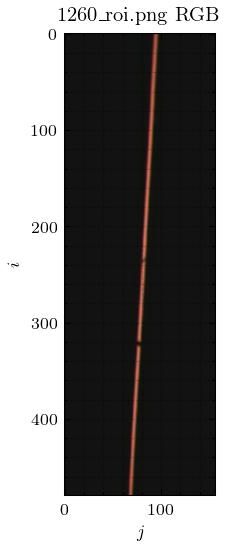

In [254]:
image_name = '1260_roi.png'
image = cv2.imread(image_name, cv2.IMREAD_COLOR_RGB)
image = cv2.GaussianBlur(image, (3, 3), 0)
# image = cv2.medianBlur(image, 7)
# image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
# image = cv2.bilateralFilter(image, 9, 75, 75)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
red, green, blue = cv2.split(image)

data = {
    'gray':  { 'img': gray  },
    'red':   { 'img': red   },
    'green': { 'img': green },
    'blue':  { 'img': blue  },
}

plt.xlabel('$j$')
plt.ylabel('$i$')
plt.imshow(image)
plt.title(image_name + ' RGB')
plt.show()

## Координаты максимумов

y =  -0.0559 x + 94.86
std = [0.00011771 0.03257019]


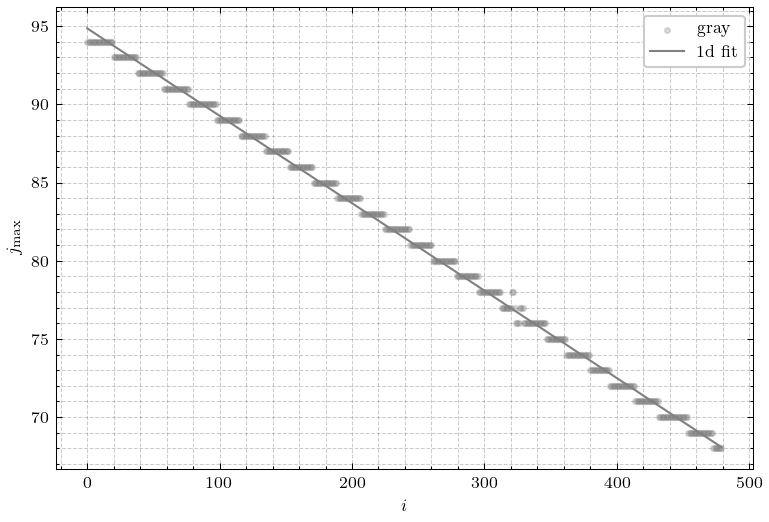

y =  -0.05592 x + 94.81
std = [0.00011683 0.03232522]


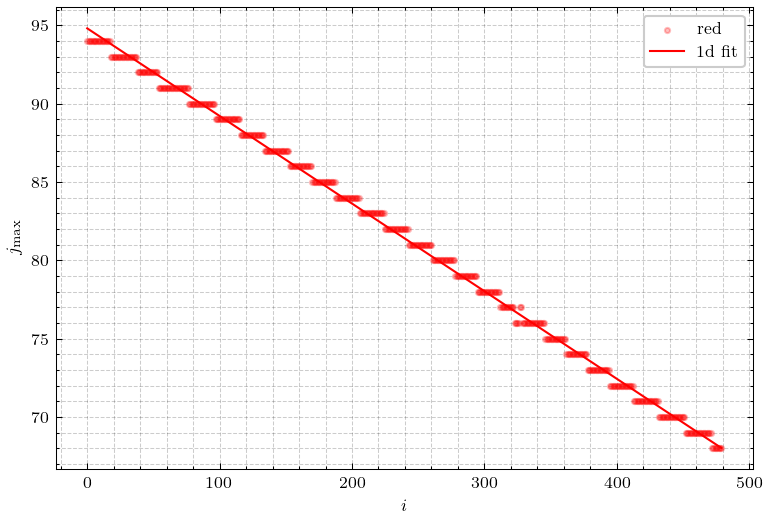

y =  -0.05584 x + 94.89
std = [0.00011793 0.0326305 ]


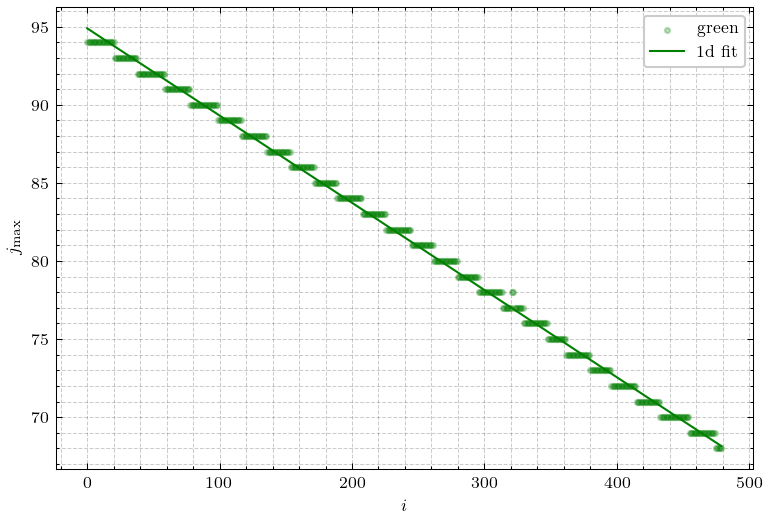

y =  -0.05661 x + 94.79
std = [0.00116289 0.32176701]


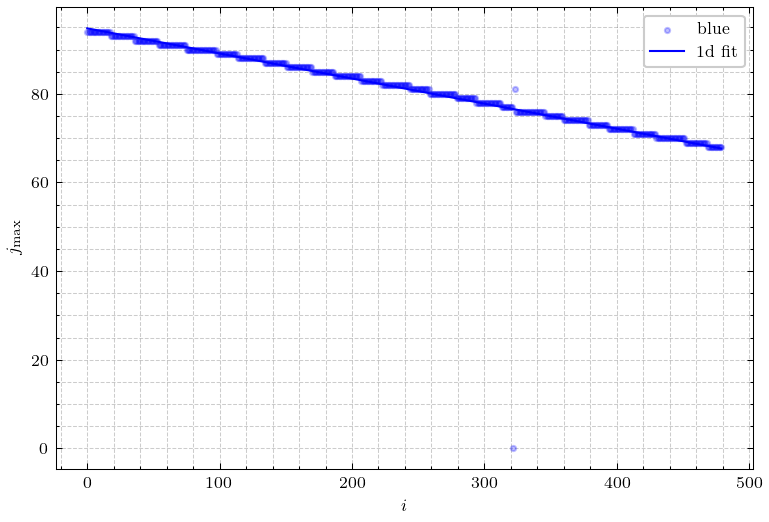

In [255]:
fit_order = 1

def j_maxs(img_array):
    res = []
    for i in range(img_array.shape[0]):
        res.append(np.argmax(img_array[i]))
    return np.array(res)

for color, color_data in data.items():
    img_array = color_data['img']
    i_arr = np.arange(img_array.shape[0])
    j_arr = j_maxs(img_array)
    plt.scatter(i_arr, j_arr, label=color, color=color, alpha=.25)
    popt, pcov = np.polyfit(i_arr, j_arr, fit_order, cov=True)
    p = np.poly1d(popt)
    plt.plot(i_arr, p(i_arr), label=f'{fit_order}d fit', color=color)

    print(f'y = {str(p).replace('\n', '')}')
    print(f'std = {np.sqrt(np.diag(pcov))}') # https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

    plt.xlabel('$i$')
    plt.ylabel(r'$j_\text{max}$')
    plt.legend()
    plt.show()

    color_data['i_arr'] = i_arr
    color_data['j_max'] = j_arr
    color_data['j_fit'] = j_arr
    # w = 50
    # color_data['j_fit'] = (np.convolve(j_arr, np.ones(w), 'same') / w).round().astype(int)
    # color_data['j_fit'] = savgol_filter(j_arr, 100, 3).round().astype(int)
    # color_data['j_fit'] = p(i_arr).round().astype(int)

## Яркость в максимуме и яркость на оси в зависимости от i (одиночные пиксели)

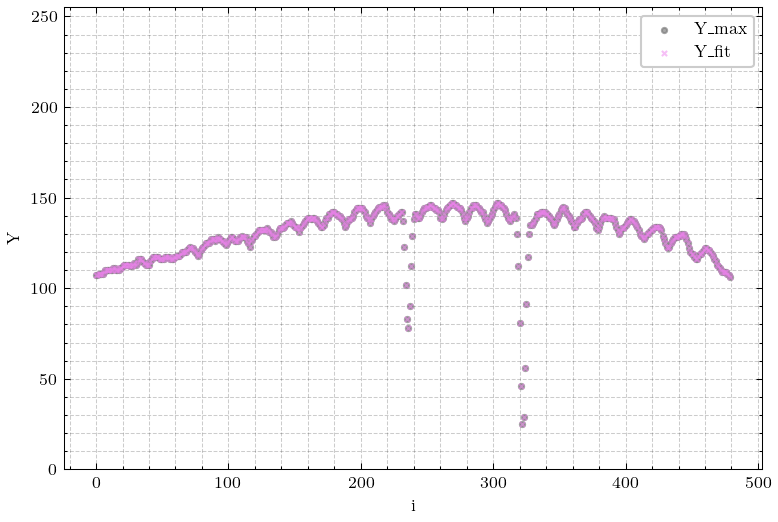

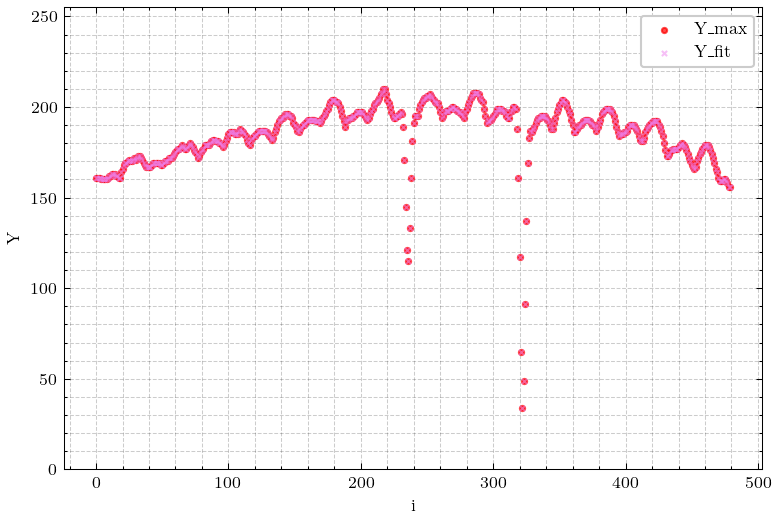

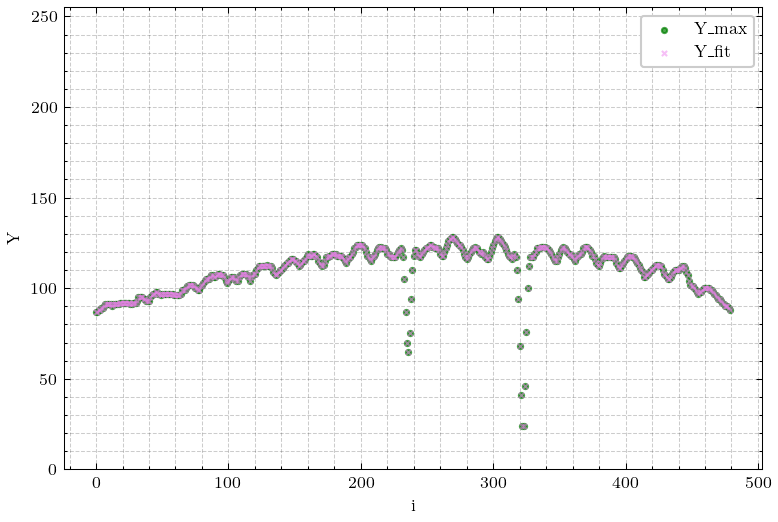

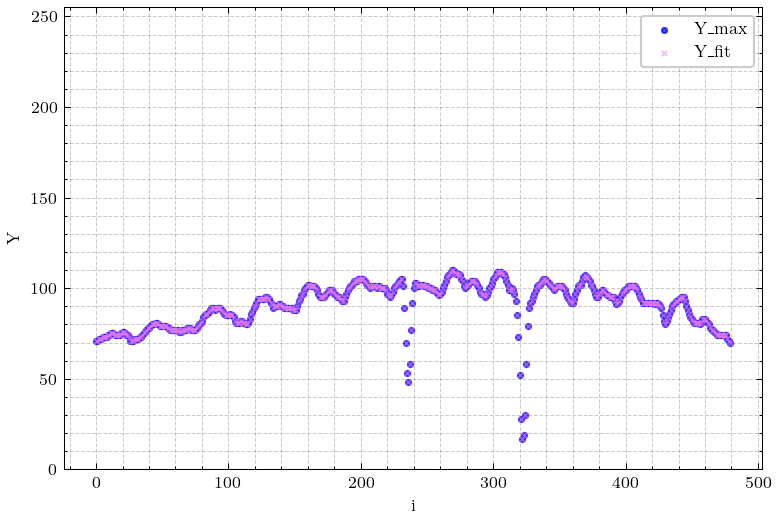

In [256]:
for color, color_data in data.items():
    plt.ylim(0, 255)
    i_arr = color_data['i_arr']
    
    Y_max = color_data['img'][i_arr, color_data['j_max']]
    plt.scatter(i_arr, Y_max, color=color, label='Y_max', marker='o', alpha=.7)

    Y_fit = color_data['img'][i_arr, color_data['j_fit']]
    # Y_fit_smooth = savgol_filter(Y_fit, 36, 3)
    plt.scatter(i_arr, Y_fit, color='violet', label='Y_fit', marker='x', alpha=.5)

    plt.xlabel('i')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

## Яркость на оси в зависимости от i (усреднение по соседним 3, 5, 7 пикселям)

gray


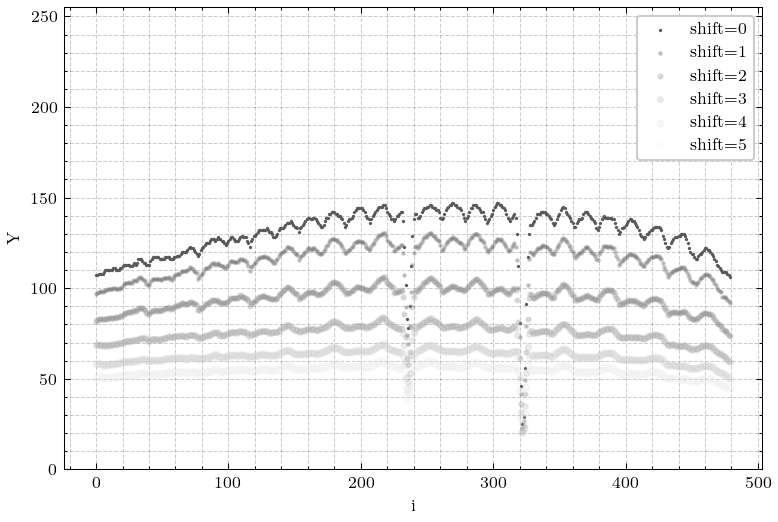

red


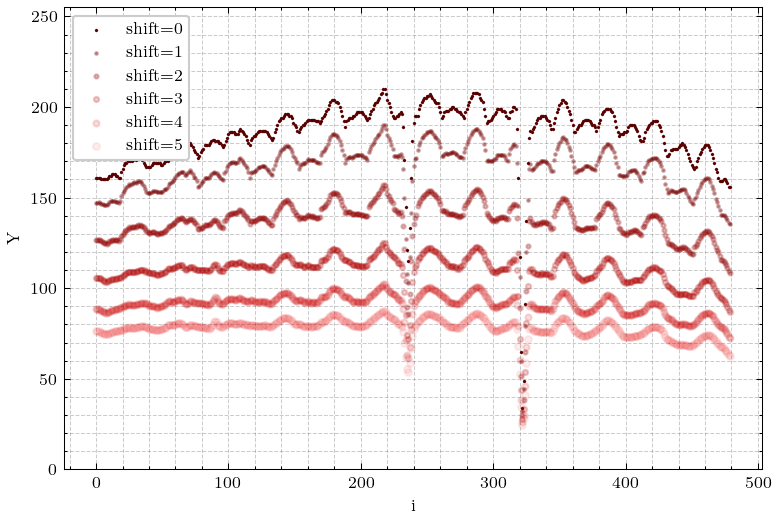

green


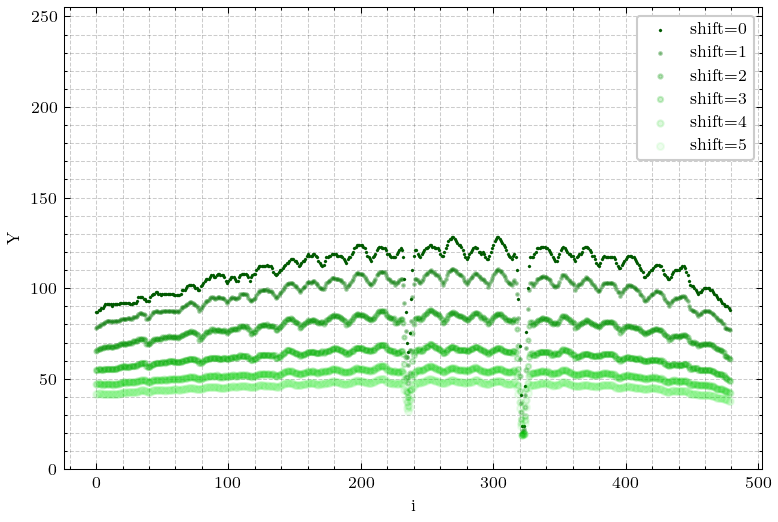

blue


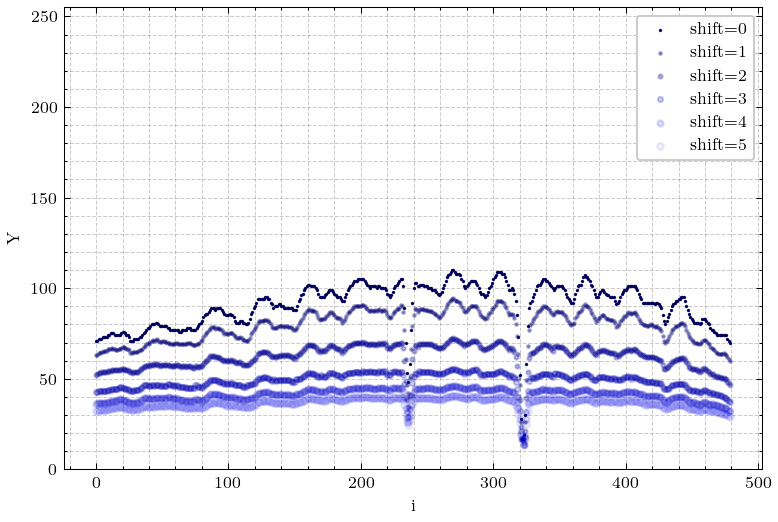

In [257]:
for color, color_data in data.items():
    base_color = mcolors.rgb_to_hsv(mcolors.to_rgb(color))
    colors = [mcolors.hsv_to_rgb((base_color[0], base_color[1], v)) for v in np.linspace(.35, .92, 6)]
    plt.rc('axes', prop_cycle=cycler(color=colors))
    plt.ylim(0, 255)
    print(color)


    i_arr = color_data['i_arr']
    j_fit = color_data['j_fit'].reshape(-1, 1)
    j_idx = j_fit

    Y = color_data['img'][i_arr, color_data['j_fit']]
    # Y = savgol_filter(Y, 36, 3)
    
    color_data['Y_shift_0'] = Y
    plt.scatter(i_arr, Y, label='shift=0', marker='x', s=1)

    for shift in range(1, 6):
        j_idx = np.concat((j_fit - shift, j_idx, j_fit + shift), axis=1)

        Y_data = color_data['img'][i_arr.reshape(-1, 1), j_idx]
        Y = Y_data.mean(axis=1)
        # Y = savgol_filter(Y, 36, 3)

        color_data[f'Y_shift_{shift}'] = Y
        plt.scatter(i_arr, Y, label=f'{shift=}', alpha=.4-shift/15, s=shift*2.4 - .8)


    plt.xlabel('i')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

## Средняя пороговая яркость в зависимости от i (порог 0.999, 0.95, 0.9, 0.85, 0.8, 0.75)

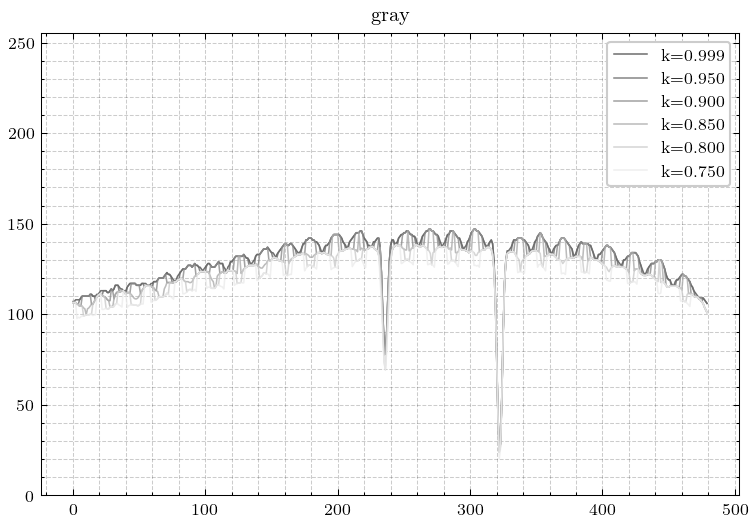

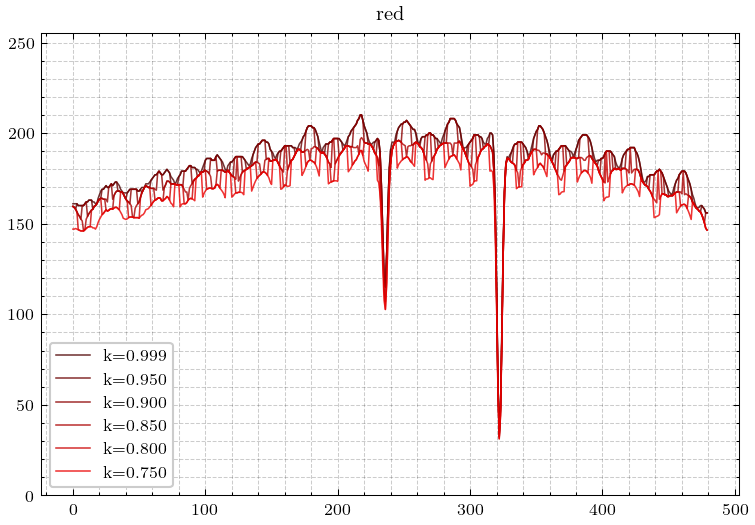

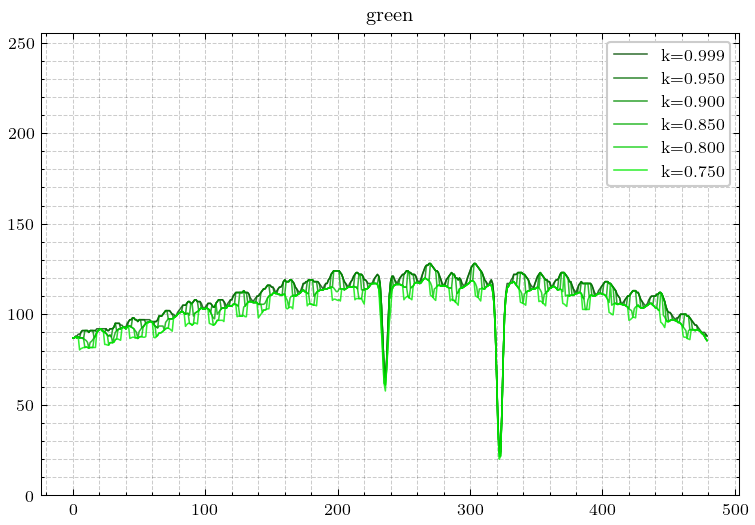

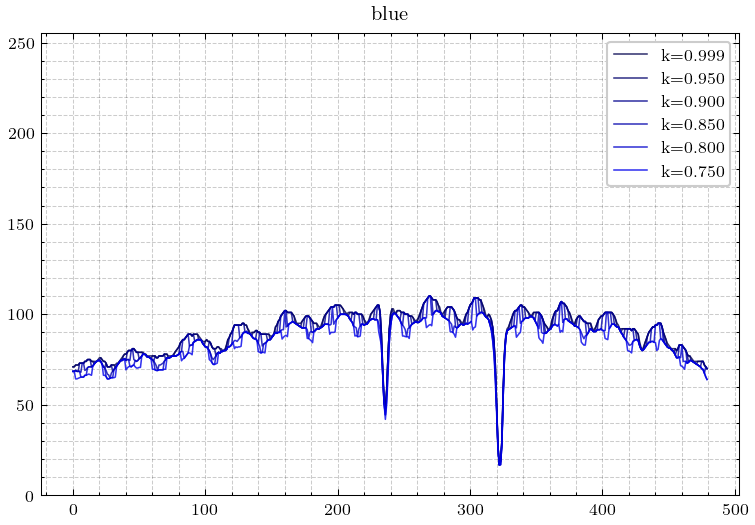

In [258]:
for color, color_data in data.items():
    base_color = mcolors.rgb_to_hsv(mcolors.to_rgb(color))
    colors = [mcolors.hsv_to_rgb((base_color[0], base_color[1], v)) for v in np.linspace(.3, .92, 6)]
    plt.rc('axes', prop_cycle=cycler(color=colors))
    plt.ylim(0, 255)

    i_arr = color_data['i_arr']
    img_array = color_data['img']
    Y_max = img_array.max(axis=1)

    for k in [0.999, 0.95, 0.9, 0.85, 0.8, 0.75]:
        Y_min = Y_max * k
        num_mask = np.ones(shape=img_array.shape) * Y_min.reshape(-1, 1)
        Y = np.ma.masked_array(img_array, img_array <= num_mask).mean(axis=1).data
        plt.plot(i_arr, Y, label=f'{k=:.3f}', lw=.75, alpha=.8)
    
    plt.title(color)
    plt.legend()
    plt.show()

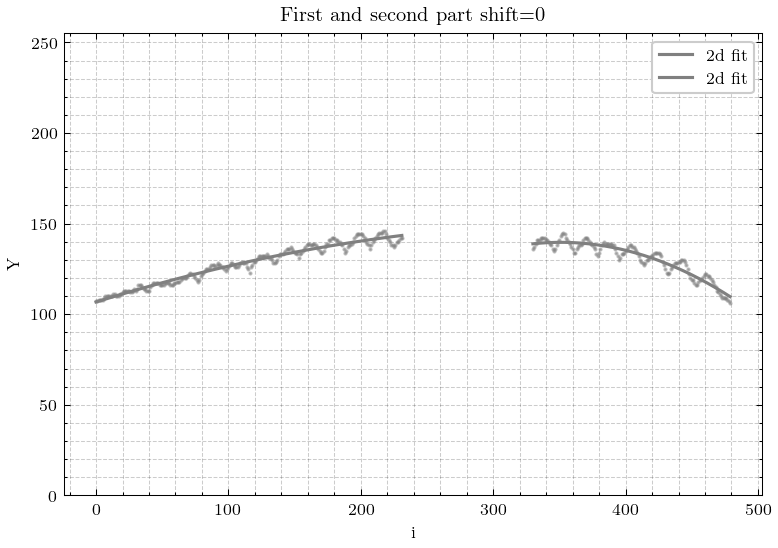

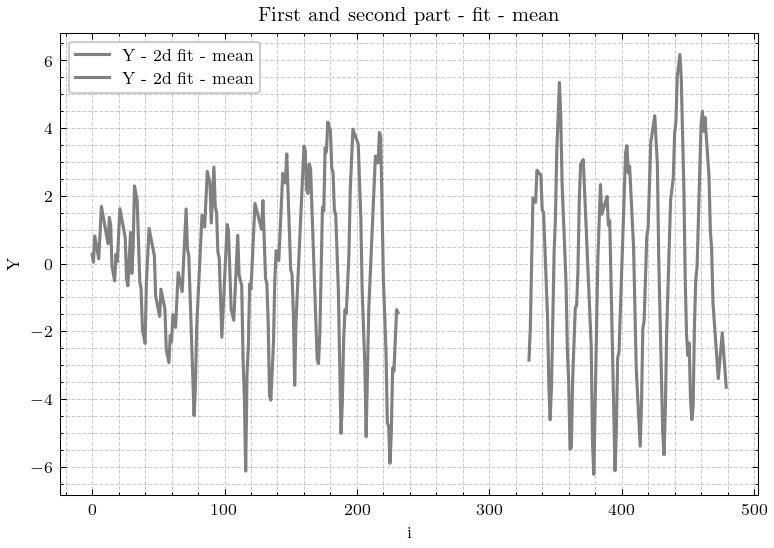

max freq: 0.05603448275862069


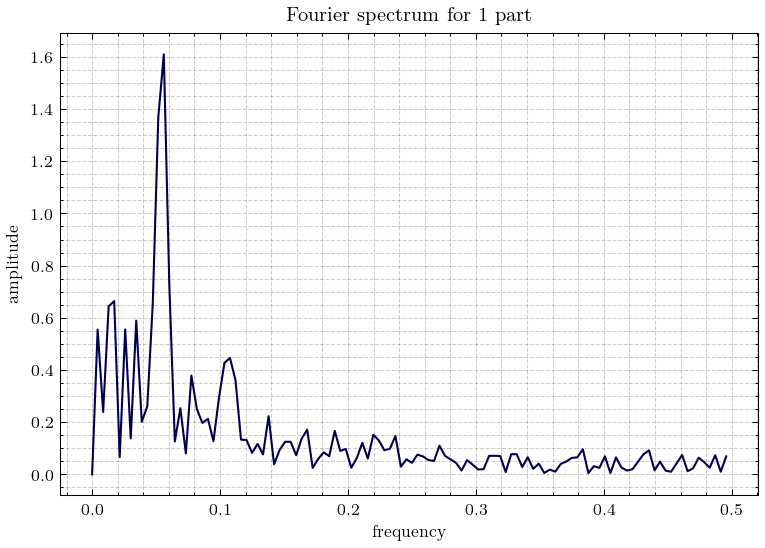

max freq: 0.05333333333333334


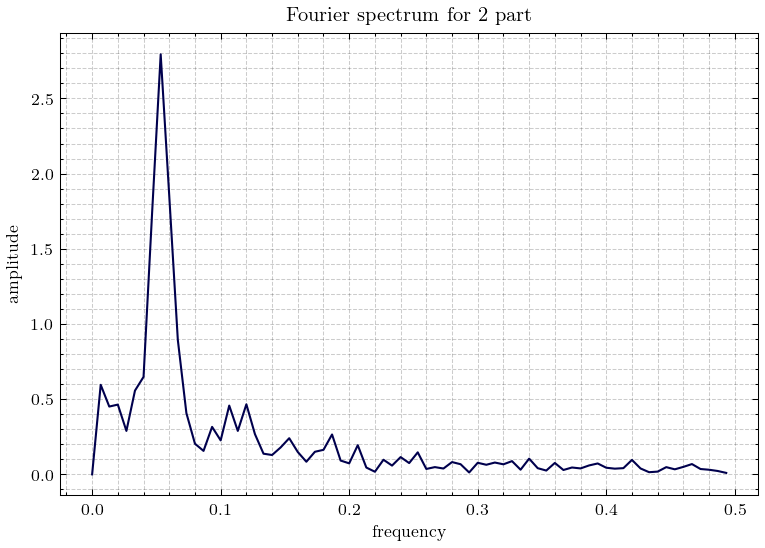

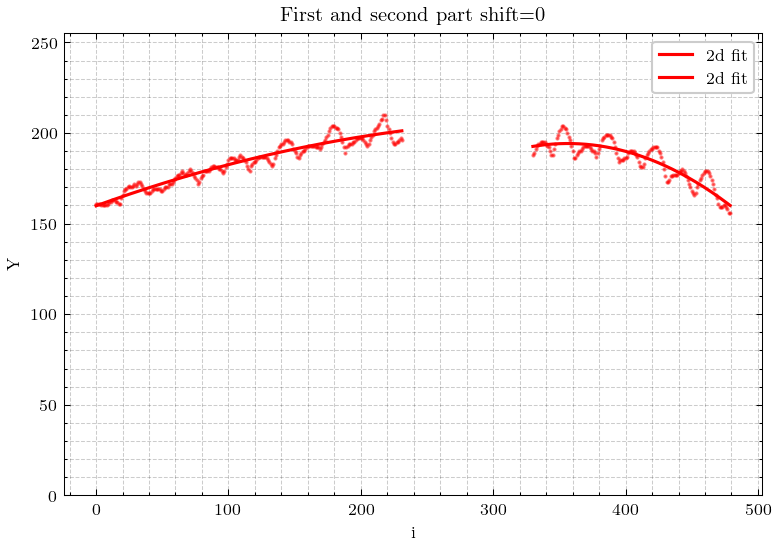

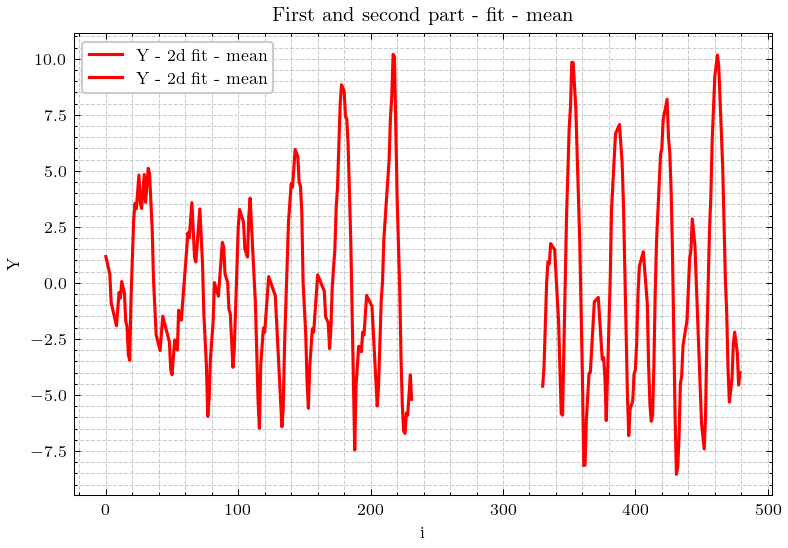

max freq: 0.02586206896551724


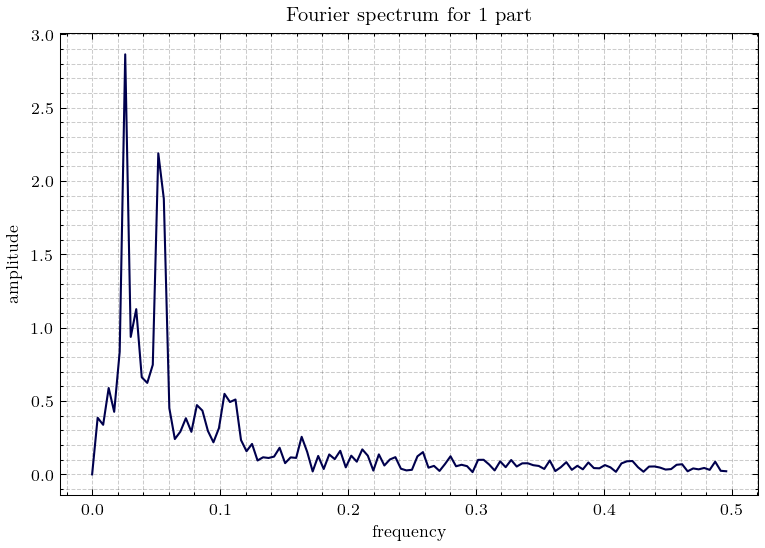

max freq: 0.02666666666666667


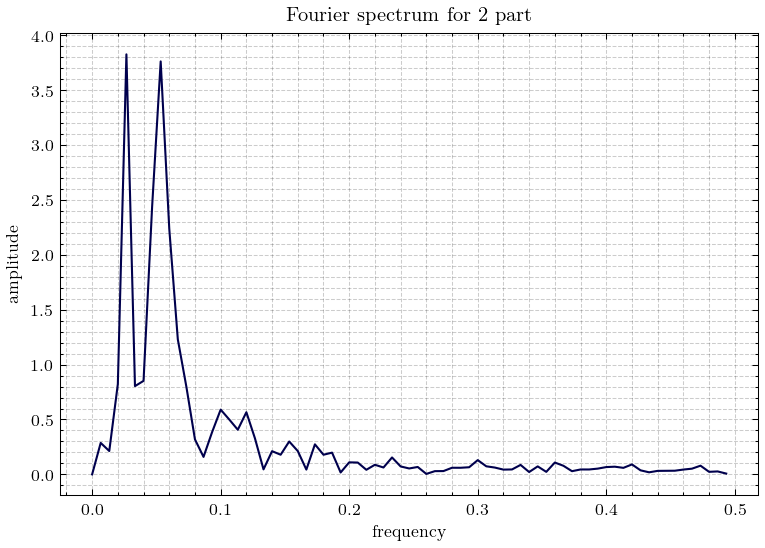

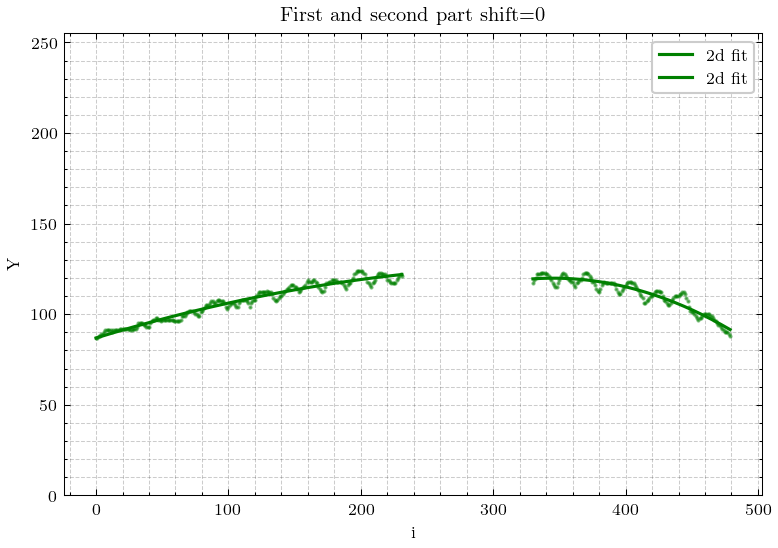

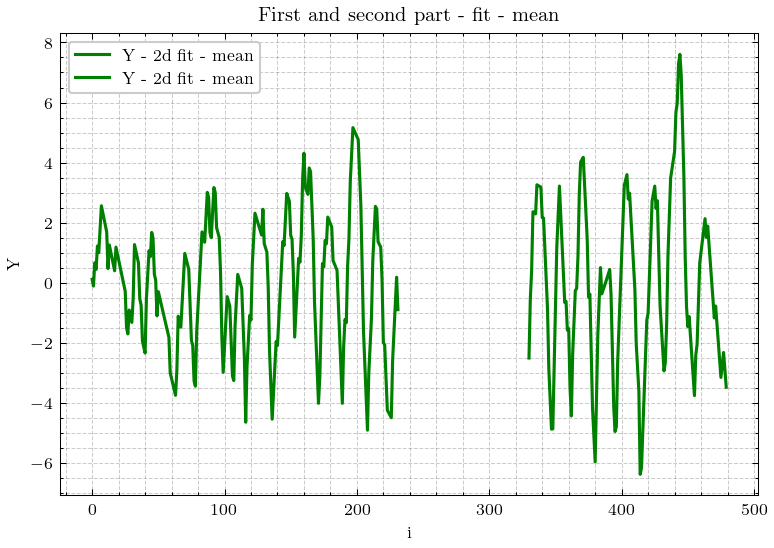

max freq: 0.05603448275862069


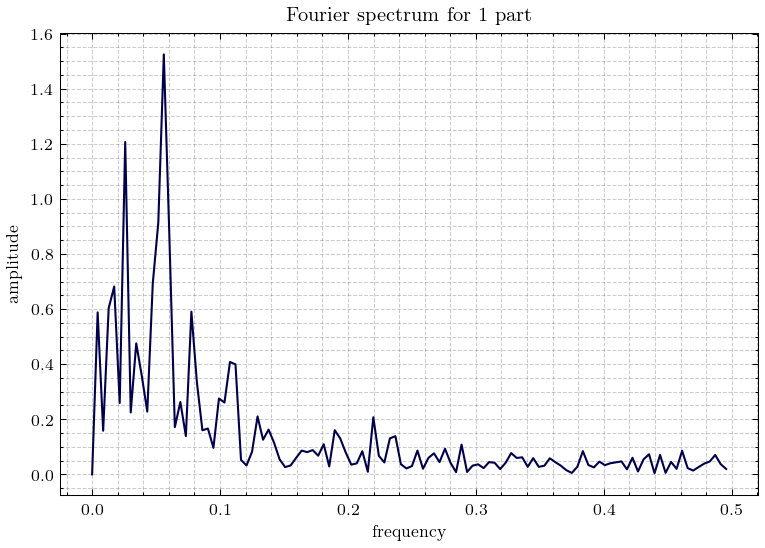

max freq: 0.05333333333333334


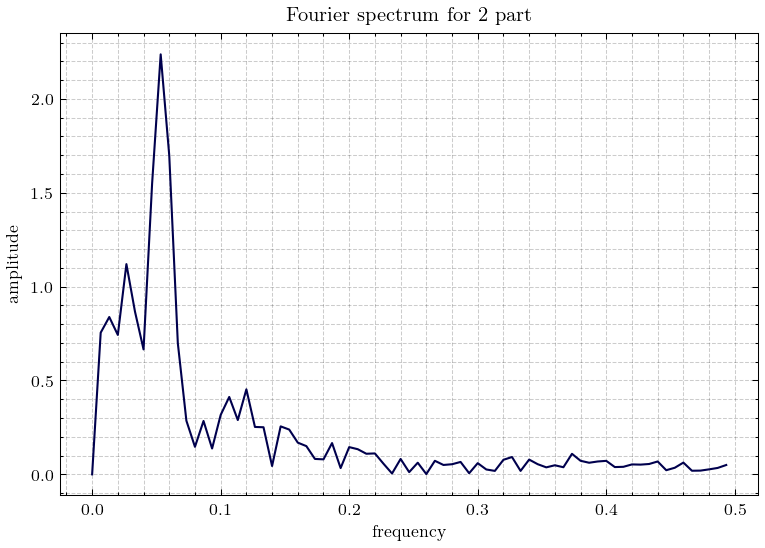

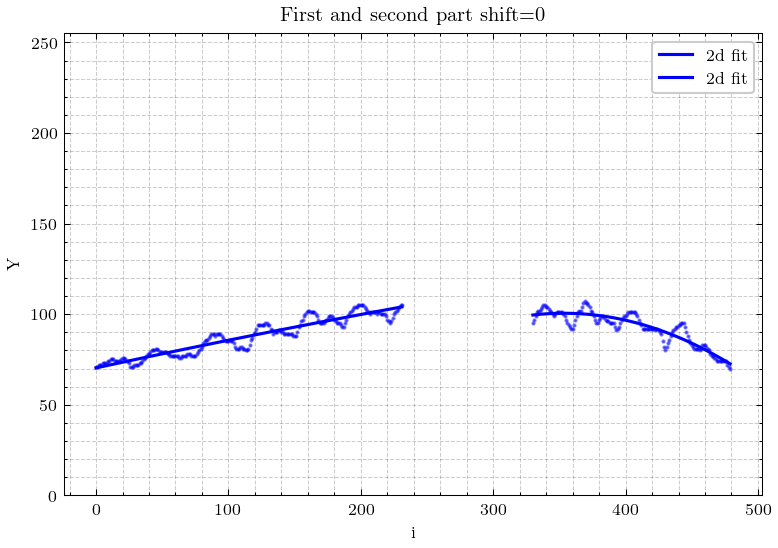

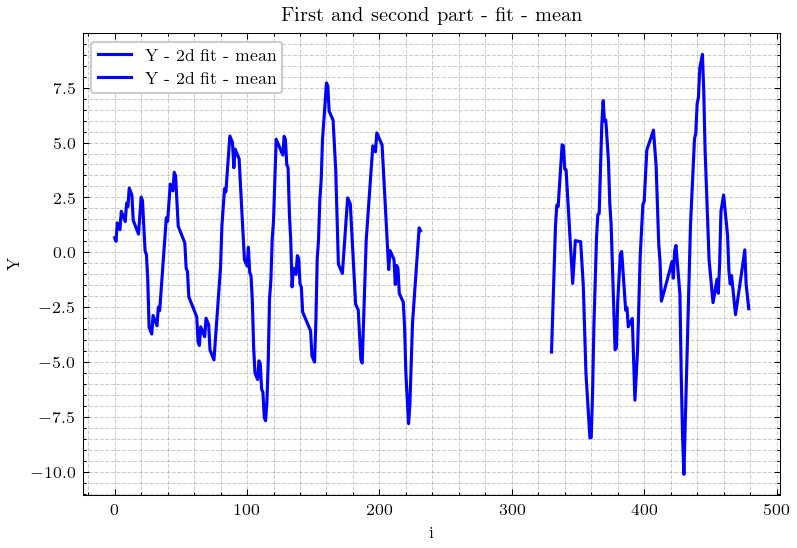

max freq: 0.02586206896551724


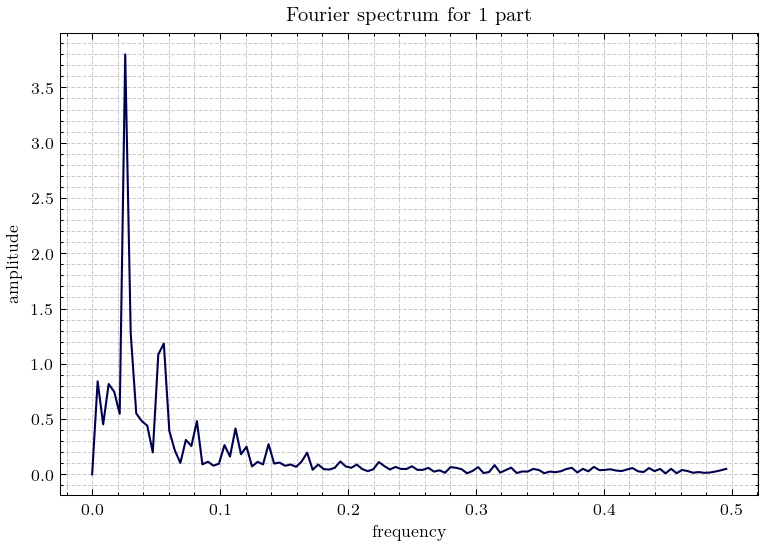

max freq: 0.02666666666666667


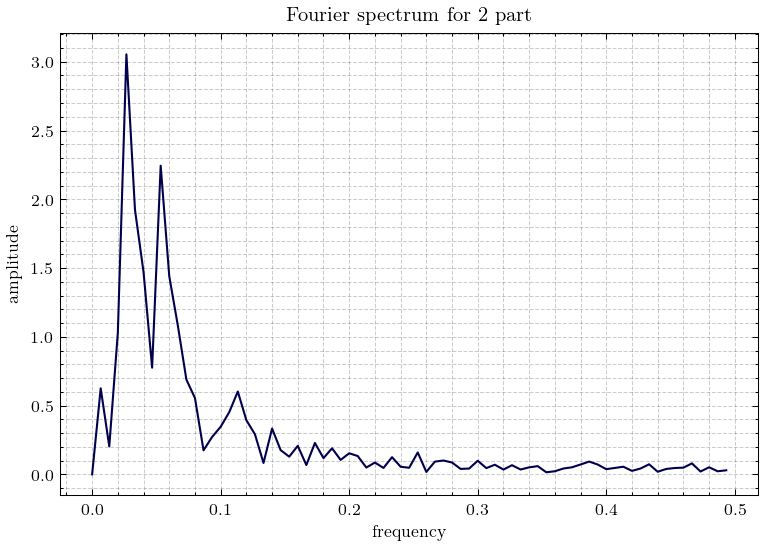

In [259]:
def surface2d(coefficients, x_grid, y_grid):
    return coefficients[0] + \
    coefficients[1] * x_grid + \
    coefficients[2] * y_grid + \
    coefficients[3] * x_grid**2 + \
    coefficients[4] * x_grid * y_grid + \
    coefficients[5] * y_grid**2

coeffs = np.array([ 7.79798226e+01,  7.55005490e-02,  1.85880640e-01, -2.45700693e-04,
        3.39881677e-06, -4.18551005e-04])

for color, color_data in data.items():
    order = 2
    shift = 0

    # ================= RAW DATA =================
    i_arr = color_data['i_arr']
    # idx = ((i_arr <= 231) | (i_arr >= 240)) & ((i_arr <= 315) | (i_arr >= 330))
    idx_first = (i_arr <= 231)
    idx_second = (i_arr >= 330)
    i_first = i_arr[idx_first]
    i_second = i_arr[idx_second]
    Y_first = color_data[f'Y_shift_{shift}'][idx_first]
    Y_second = color_data[f'Y_shift_{shift}'][idx_second]
    i_and_Y = [(i_first, Y_first), (i_second, Y_second)]

    # ================= FIRST AND SECOND PART =================
    plt.ylim(0, 255)

    for i, Y in i_and_Y:
        plt.scatter(i, Y, s=1, color=color, alpha=.5)

        popt, pcov = np.polyfit(i, Y, order, cov=True)
        p = np.poly1d(popt)
        plt.plot(i, p(i), color=color, lw=1.5, label=f'{order}d fit')

    plt.legend()
    plt.xlabel('i')
    plt.ylabel('Y')
    plt.title(f'First and second part {shift=}')
    plt.show()

    # ================= PARTS - POLY - MEAN =================
    for i, Y in i_and_Y:
        popt, pcov = np.polyfit(i, Y, order, cov=True)
        p = np.poly1d(popt)
        Y_mod = Y - p(i)
        Y_mod -= Y_mod.mean()
        plt.plot(i, Y_mod, color=color, lw=1.5, label=f'Y - {order}d fit - mean')

    plt.legend()
    plt.xlabel('i')
    plt.ylabel('Y')
    plt.title(f'First and second part - fit - mean')
    plt.show()

    # ================= FFT =================
    for number, (i, Y) in enumerate(i_and_Y):
        popt, pcov = np.polyfit(i, Y, order, cov=True)
        p = np.poly1d(popt)
        Y_mod = Y - p(i)
        Y_mod -= Y_mod.mean()

        N = len(Y_mod)
        fft_result = np.fft.fft(Y_mod)
        freq = np.fft.fftfreq(N, 1)

        positive_freq_idx = np.where(freq >= 0)
        freq_positive = freq[positive_freq_idx]
        amplitude = 2 * np.abs(fft_result[positive_freq_idx]) / N  # Нормализация
        # phase = np.angle(fft_result[positive_freq_idx])

        print(f'max freq: {freq_positive[amplitude.argmax()]}')
        plt.plot(freq_positive, amplitude)

        plt.xlabel('frequency')
        plt.ylabel('amplitude')
        plt.title(f'Fourier spectrum for {number+1} part')
        plt.show()

    # ================= FILTER =================

    # filter max freq
    # max_freq = freq_positive[amplitude.argmax()]
    # max_ampl = amplitude.max()
    # sin = np.sin(2 * np.pi * max_freq * i_arr) * max_ampl
    # # plt.plot(i_arr, Y_first)
    # # plt.plot(i_arr, sin)
    # plt.plot(i_arr, Y - sin)
    # plt.scatter(i_arr, Y, s=.3)
    # plt.ylim(0, 255)
    # plt.show()

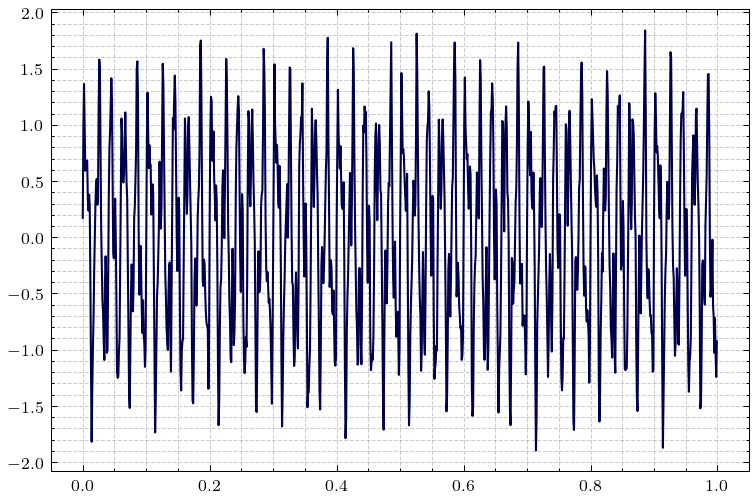

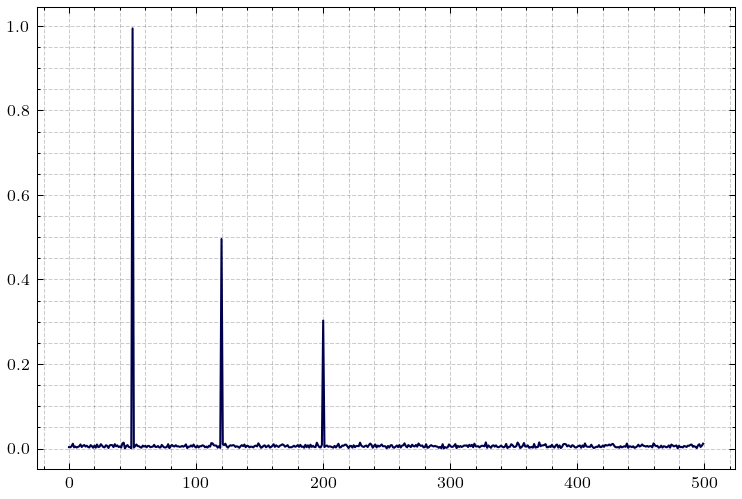

In [260]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Создадим тестовый сигнал (или загрузите свои данные)
fs = 1000  # Частота дискретизации (Гц)
t = np.arange(0, 1, 1/fs)  # Временная ось (1 секунда)

# Создаем сигнал из нескольких синусоид разной частоты
f1, f2, f3 = 50, 120, 200  # Частоты в Гц
signal = np.sin(2*np.pi*f1*t) + 0.5*np.sin(2*np.pi*f2*t) + 0.3*np.sin(2*np.pi*f3*t)
signal += 0.1*np.random.randn(len(t))  # Добавляем шум

# 2. Вычисляем преобразование Фурье
fft_result = np.fft.fft(signal)
N = len(signal)
freq = np.fft.fftfreq(N, 1/fs)  # Получаем частотную ось

# 3. Для визуализации берём только положительные частоты и вычисляем амплитуду
positive_freq_idx = np.where(freq >= 0)
freq_positive = freq[positive_freq_idx]
amplitude = 2 * np.abs(fft_result[positive_freq_idx]) / N  # Нормализация

# 4. Визуализация

# Исходный сигнал
plt.plot(t, signal)
plt.show()

# Спектр Фурье
plt.plot(freq_positive, amplitude)
# plt.xlim(0, fs/2)  # Ограничиваем до частоты Найквиста
plt.show()


In [261]:
1/0.02586206896551724

38.666666666666664